In [0]:
# Load cleaned data from snowflake

sfOptions = {
  "sfURL": "https://zjrxsoa-ylb28964.snowflakecomputing.com",
  "sfUser": "YOUR USERNAME",
  "sfPassword": "YOUR PASSWORD",
  "sfDatabase": "ENERGY_DB",
  "sfSchema": "PUBLIC",
  "sfWarehouse": "COMPUTE_WH"
}

df = spark.read \
    .format("snowflake") \
    .options(**sfOptions) \
    .option("dbtable", "SOLAR_IRRADIANCE") \
    .load()


In [0]:
# get rid of spaces in names to make it spark friendly

# Clean up all column names
for col_name in df.columns:
    clean_name = col_name.lower().replace(" ", "_").replace('"', "").replace("`", "")
    df = df.withColumnRenamed(col_name, clean_name)

In [0]:
# Convert necessary cols into floats
from pyspark.sql.types import FloatType

numeric_cols = [
    "ghi", "dni", "dhi", "temperature", "wind_speed",
    "relative_humidity", "clearsky_ghi", "clearsky_dni",
    "clearsky_dhi", "precipitable_water", "solar_zenith_angle",
    "dew_point"
]

for col_name in numeric_cols:
    df = df.withColumn(col_name, df[col_name].cast(FloatType()))

In [0]:
from pyspark.sql.functions import col, when, concat_ws, to_timestamp 
# Create datetime column
df = df.withColumn("datetime", to_timestamp(concat_ws("-", "year", "month", "day", "hour"), "yyyy-M-d-H"))

# create cloudiness_ratio
df = df.withColumn("cloudiness_ratio", when(col("ghi") > 0, col("dhi") / col("ghi")).otherwise(0))


In [0]:

# Feature engineering 1: creating date and day of year col
from pyspark.sql.functions import lpad, concat_ws

# Ensure year/month/day are all string and padded
df = df.withColumn("year_str", col("year").cast("string"))
df = df.withColumn("month_str", lpad(col("month").cast("string"), 2, "0"))
df = df.withColumn("day_str", lpad(col("day").cast("string"), 2, "0"))

# Now build proper "yyyy-MM-dd" string
df = df.withColumn("date_str", concat_ws("-", "year_str", "month_str", "day_str"))

# Check the result
df.select("year", "month", "day", "date_str").show(5, truncate=False)


+----+-----+---+----------+
|year|month|day|date_str  |
+----+-----+---+----------+
|2022|1    |1  |2022-01-01|
|2022|1    |1  |2022-01-01|
|2022|1    |1  |2022-01-01|
|2022|1    |1  |2022-01-01|
|2022|1    |1  |2022-01-01|
+----+-----+---+----------+
only showing top 5 rows



In [0]:
# feature engineering 2
from pyspark.sql.functions import to_date, dayofyear, to_date

df = df.withColumn("date", to_date("date_str", "yyyy-MM-dd"))
df = df.withColumn("day_of_year", dayofyear("date"))

# Optional cleanup
df = df.drop("year_str", "month_str", "day_str", "date_str")


In [0]:
# Feature engineering
import math
from pyspark.sql.functions import (
    col, sin, cos, lit, pi, when, dayofyear, radians, to_date, lpad, concat_ws
)

# Cyclical features
df = df.withColumn("hour_sin", sin(lit(2) * lit(math.pi) * col("hour") / lit(24)))
df = df.withColumn("hour_cos", cos(lit(2) * lit(math.pi) * col("hour") / lit(24)))
df = df.withColumn("month_sin", sin(lit(2) * lit(math.pi) * col("month") / lit(12)))
df = df.withColumn("month_cos", cos(lit(2) * lit(math.pi) * col("month") / lit(12)))

# Daylight indicator
df = df.withColumn("is_daylight", when(col("ghi") > 0, 1).otherwise(0))

# Clearsky index + Cloudiness ratio
df = df.withColumn("clearsky_index", col("ghi") / (col("clearsky_ghi") + lit(1e-5)))  # avoid div by 0
df = df.withColumn("cloudiness_ratio", 1 - col("clearsky_index"))

# Optional: dewpoint - temperature
df = df.withColumn("temp_dew_diff", col("temperature") - col("dew_point"))

# Optional: humidity * wind speed (storm/fog proxy)
df = df.withColumn("humid_wind_index", col("relative_humidity") * col("wind_speed"))

# Optional: cast city to categorical (for some models)
# Leave as is for tree models; you’d encode it later for MLlib or sklearn


In [0]:
# Add altitude, latitude, longitude
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

# Extended location data: (station_id, city, lat, lon, altitude in meters)
location_data = [
    ("727930", "seattle_wa", 47.6062, -122.3321, 53.0),
    ("725650", "denver_co", 39.7392, -104.9903, 1609.0),
    ("722997", "houston_tx", 29.7604, -95.3698, 13.0),
    ("747187", "phoenix_az", 33.4484, -112.0740, 331.0),
    ("722020", "miami_fl", 25.7617, -80.1918, 2.0)
]

location_schema = StructType([
    StructField("location_id", StringType(), True),
    StructField("city", StringType(), True),
    StructField("latitude", DoubleType(), True),
    StructField("longitude", DoubleType(), True),
    StructField("altitude", DoubleType(), True)
])

location_df = spark.createDataFrame(location_data, schema=location_schema)

location_df = location_df.drop("city")
df = df.join(location_df, on="location_id", how="left")


In [0]:
# Drop cols not used for modeling
# Keep for later
datetime_cols = df.select("city", "year", "month", "day", "hour", "minute", "datetime")

columns_to_drop = ["source_file", "datetime", "date", "year", "day", "minute", "location_id"]
df = df.drop(*columns_to_drop)


In [0]:
datetime_cols.show(5)

+---------+----+-----+---+----+------+-------------------+
|     city|year|month|day|hour|minute|           datetime|
+---------+----+-----+---+----+------+-------------------+
|denver_co|2022|    1|  1|   0|    30|2022-01-01 00:00:00|
|denver_co|2022|    1|  1|   1|    30|2022-01-01 01:00:00|
|denver_co|2022|    1|  1|   2|    30|2022-01-01 02:00:00|
|denver_co|2022|    1|  1|   3|    30|2022-01-01 03:00:00|
|denver_co|2022|    1|  1|   4|    30|2022-01-01 04:00:00|
+---------+----+-----+---+----+------+-------------------+
only showing top 5 rows



In [0]:
## Modeling ###

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# 1. Encode city (StringIndexer, OneHotEncoder)
indexer = StringIndexer(inputCol="city", outputCol="city_index")
df = indexer.fit(df).transform(df)

encoder = OneHotEncoder(inputCols=["city_index"], outputCols=["city_ohe"])
df = encoder.fit(df).transform(df)

# 2. Vector Assembler
feature_cols = [
    "dni", "dhi", "temperature", "wind_speed", "relative_humidity",
    "clearsky_ghi", "clearsky_dni", "clearsky_dhi", "precipitable_water",
    "solar_zenith_angle", "dew_point", "hour_sin", "hour_cos",
    "month_sin", "month_cos", "day_of_year", "is_daylight",
    "clearsky_index", "cloudiness_ratio", "temp_dew_diff",
    "humid_wind_index", "latitude", "longitude", "altitude",
    "city_ohe"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_model = assembler.transform(df)

# Train-test split (after all transformations)
train_df, test_df = df_model.randomSplit([0.8, 0.2], seed=42)



In [0]:
# check
df_model.select("features", "ghi").show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
|features                                                                                                                                                                                                                                                                                         |ghi|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
|(28,[2,3,4,8,9,10,12,13,14,15,18,19,20,21,22,23,24],[22.100000381469727,4.199999809265137,98.37999725341797,3.0

In [0]:
# Baseline model, add hyperparameters later
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(featuresCol="features", labelCol="ghi")
lr_model = lr.fit(train_df)

#predictions
predictions = lr_model.transform(test_df)
predictions.select("prediction", "ghi").show(5)


+------------------+---+
|        prediction|ghi|
+------------------+---+
|-4.258749793297568|0.0|
|2.0592026869020685|0.0|
| 2.642648088068057|0.0|
|3.0771651373565874|0.0|
| 3.454321661051978|0.0|
+------------------+---+
only showing top 5 rows



In [0]:
# Evaluate baseline model
evaluator = RegressionEvaluator(
    labelCol="ghi",
    predictionCol="prediction",
    metricName="rmse"  # Root Mean Square Error
)

rmse = evaluator.evaluate(predictions)
r2 = RegressionEvaluator(labelCol="ghi", predictionCol="prediction", metricName="r2").evaluate(predictions)

print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")


RMSE: 40.61
R2: 0.9801


In [0]:
## Tree based model
# Random forest
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol="features", labelCol="ghi", seed=42)
rf_model = rf.fit(train_df)
rf_preds = rf_model.transform(test_df)

# Gradient boosted trees
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol="features", labelCol="ghi", seed=42)
gbt_model = gbt.fit(train_df)
gbt_preds = gbt_model.transform(test_df)


In [0]:
# Eval RF and gradient boosted trees
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="ghi", predictionCol="prediction", metricName="rmse")

rmse_rf = evaluator.evaluate(rf_preds)
rmse_gbt = evaluator.evaluate(gbt_preds)

print(f"Random Forest RMSE: {rmse_rf}")
print(f"GBT RMSE: {rmse_gbt}")


Random Forest RMSE: 24.287229603506297
GBT RMSE: 16.743364874084957


In [0]:
# XGBoost not supported, convert to pandas to model

train_pd = train_df.select("features", "ghi").toPandas()
test_pd = test_df.select("features", "ghi").toPandas()

import xgboost as xgb
from sklearn.metrics import mean_squared_error

dtrain = xgb.DMatrix(train_pd["features"].tolist(), label=train_pd["ghi"])
dtest = xgb.DMatrix(test_pd["features"].tolist(), label=test_pd["ghi"])

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
}

xgb_model = xgb.train(params, dtrain, num_boost_round=100)

preds = xgb_model.predict(dtest)
xgb_rmse = mean_squared_error(test_pd["ghi"], preds, squared=False)
print(f"XGBoost RMSE: {xgb_rmse:.2f}")



XGBoost RMSE: 3.33


In [0]:
# Light GBM
from synapse.ml.lightgbm import LightGBMRegressor

lgbm = LightGBMRegressor(
    labelCol="ghi",
    featuresCol="features",
    objective="regression"
)
lgbm_model = lgbm.fit(train_df)

predictions = lgbm_model.transform(test_df)

from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol="ghi", predictionCol="prediction", metricName="rmse"
)

light_gbm_rmse = evaluator.evaluate(predictions)
print(f"LightGBM RMSE: {light_gbm_rmse:.2f}")



LightGBM RMSE: 2.80


In [0]:
# RMSE Results
rmse_results = {
    "Baseline (Linear Regression)": rmse,
    "Random Forest": rmse_rf,
    "Gradient Boosted Tree": rmse_gbt,
    "XGBoost": xgb_rmse,
    "LightGBM": light_gbm_rmse,
}


In [0]:
rmse_results

{'Baseline (Linear Regression)': 40.60930084124851,
 'Random Forest': 24.287229603506297,
 'Gradient Boosted Tree': 16.743364874084957,
 'XGBoost': 3.3288271,
 'LightGBM': 2.8018076533643574}

In [0]:
# Hyperparameter tuning - Light GBM

from synapse.ml.lightgbm import LightGBMRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Reuse train_data and test_data from earlier

# Define the base model
lgbm = LightGBMRegressor(
    featuresCol="features",
    labelCol="ghi",  # or your actual target column
    objective="regression",
    verbosity=0,
    learningRate=0.1,
    numLeaves=31
)

# Define parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(lgbm.maxDepth, [5]) \
    .addGrid(lgbm.numLeaves, [31, 50]) \
    .addGrid(lgbm.learningRate, [0.1]) \
    .build()

# Define evaluator
evaluator = RegressionEvaluator(
    labelCol="ghi",
    predictionCol="prediction",
    metricName="rmse"
)

# Set up CrossValidator
cv = CrossValidator(
    estimator=lgbm,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=2
)

# Fit the model
cvModel = cv.fit(train_df)

# Evaluate on test set
predictions = cvModel.transform(test_df)
rmse = evaluator.evaluate(predictions)
print(f"✅ Tuned LightGBM RMSE: {rmse:.4f}")


✅ Tuned LightGBM RMSE: 3.1040


In [0]:
### Model refinement #######
### Plot predictions vs actual and check for overfitting/underfitting ##


best_model = lgbm_model
predictions = best_model.transform(test_df)


In [0]:
# Check for underfitting / overfitting
from pyspark.ml.evaluation import RegressionEvaluator

# Train set predictions
train_pred = best_model.transform(train_df)
test_pred = best_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="ghi", predictionCol="prediction", metricName="rmse")
train_rmse = evaluator.evaluate(train_pred)
test_rmse = evaluator.evaluate(test_pred)

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")


In [0]:
from pyspark.sql.functions import lit

predictions_updated = predictions.withColumn("year", lit(2023)).withColumn("day", lit(1)).withColumn("minute", lit(30))

preds_with_time = predictions_updated.join(
    datetime_cols,
    on=["city", "year", "month", "day", "hour", "minute"],
    how="left"
)

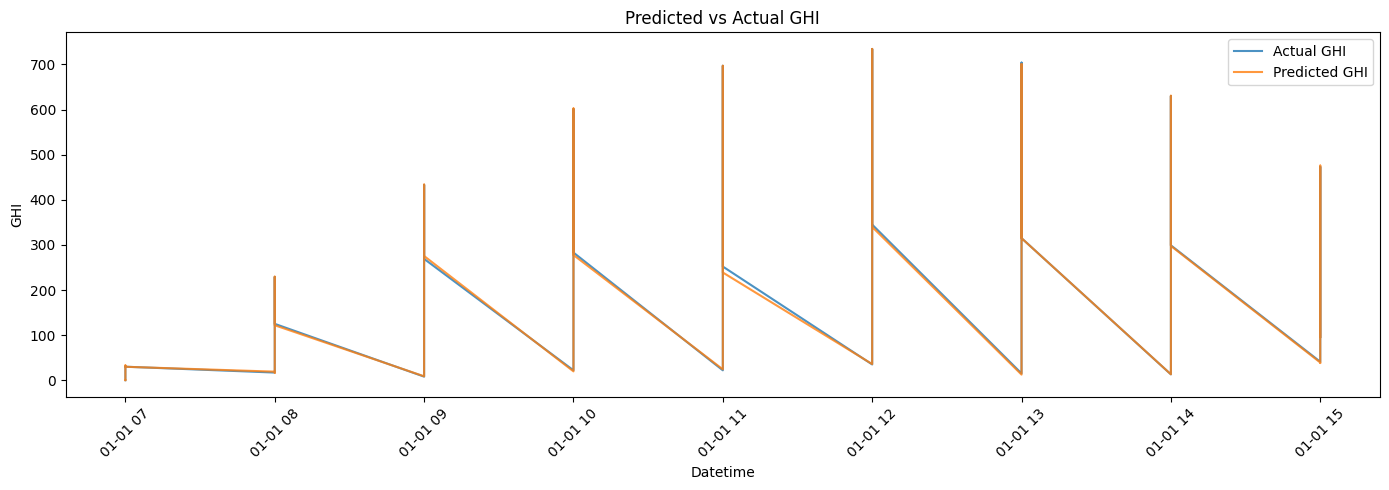

In [0]:
# Filter for daytime hours and sample more diverse records
subset = preds_with_time.filter((col("hour") >= 7) & (col("hour") <= 17)) \
                        .orderBy("datetime") \
                        .limit(500)

subset_pd = subset.select("datetime", "prediction", "ghi").toPandas()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(subset_pd["datetime"], subset_pd["ghi"], label="Actual GHI", alpha=0.8)
plt.plot(subset_pd["datetime"], subset_pd["prediction"], label="Predicted GHI", alpha=0.8)
plt.xlabel("Datetime")
plt.ylabel("GHI")
plt.title("Predicted vs Actual GHI")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


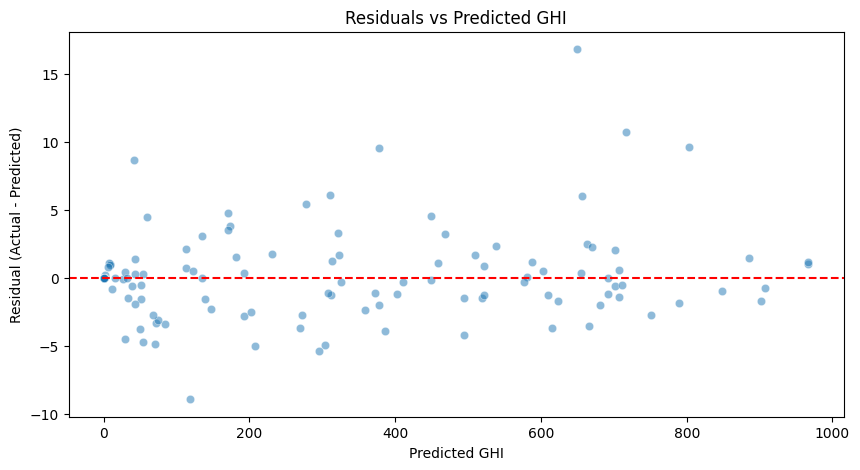

In [0]:
# Residuals

pdf = preds_with_time.select("datetime", "prediction", "ghi", "city") \
                     .orderBy("datetime") \
                     .sample(fraction=0.01) \
                     .toPandas()

# Compute residuals
pdf["residual"] = pdf["ghi"] - pdf["prediction"]


import matplotlib.pyplot as plt
import seaborn as sns

# residuals vs predicted ghi
plt.figure(figsize=(10, 5))
sns.scatterplot(x=pdf["prediction"], y=pdf["residual"], alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted GHI")
plt.xlabel("Predicted GHI")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()


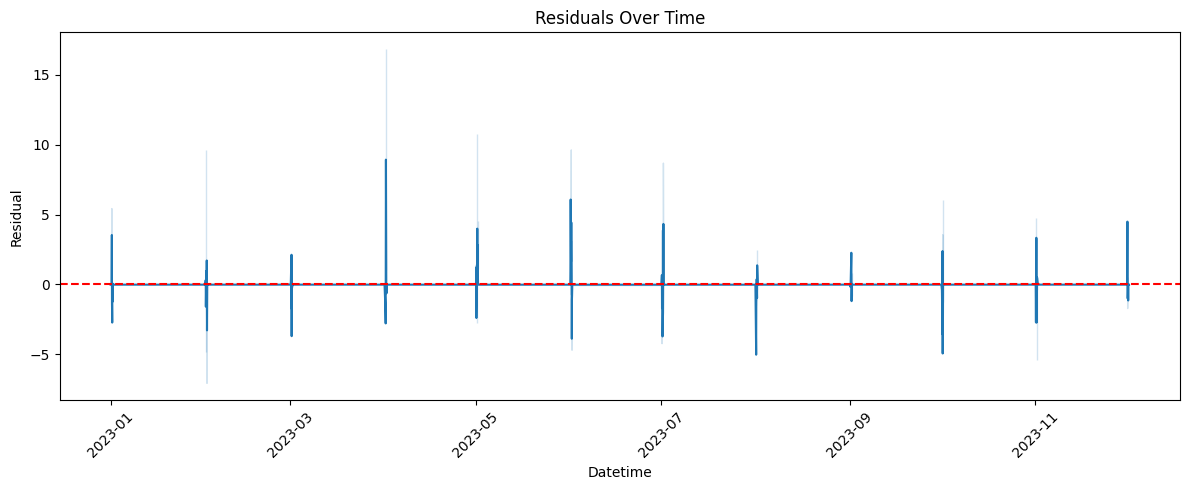

In [0]:
# Residuals vs datetime
plt.figure(figsize=(12, 5))
sns.lineplot(x=pdf["datetime"], y=pdf["residual"])
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals Over Time")
plt.xlabel("Datetime")
plt.ylabel("Residual")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [0]:
# Save best performing model

model_path = "dbfs:/models/lightgbm_final_model"

# Save model
best_model.write().overwrite().save(model_path)
